# CKD Model Training with PCA Feature Selection

This notebook enhances the original CKD model training by:
1. Performing PCA analysis for feature selection
2. Identifying the most important features
3. Training models with optimized feature sets
4. Comparing performance with and without PCA

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preprocessing

In [2]:
# Load the comprehensive CKD dataset
df = pd.read_csv('Chronic_Kidney_Dsease_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget distribution:")
print(df['Diagnosis'].value_counts())

# Display basic info
df.head()

Dataset shape: (1659, 54)

Columns: ['PatientID', 'Age', 'Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes', 'PreviousAcuteKidneyInjury', 'UrinaryTractInfections', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c', 'SerumCreatinine', 'BUNLevels', 'GFR', 'ProteinInUrine', 'ACR', 'SerumElectrolytesSodium', 'SerumElectrolytesPotassium', 'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus', 'HemoglobinLevels', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'ACEInhibitors', 'Diuretics', 'NSAIDsUse', 'Statins', 'AntidiabeticMedications', 'Edema', 'FatigueLevels', 'NauseaVomiting', 'MuscleCramps', 'Itching', 'QualityOfLifeScore', 'HeavyMetalsExposure', 'OccupationalExposureChemicals', 'WaterQuality', 'MedicalCheckupsFrequency', 'MedicationAdherence', 'HealthLi

,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
3,4,40,0,2,0,1,31.329680,0,16.020165,0.408871,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
4,5,43,0,1,1,2,23.726311,0,7.944146,0.780319,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential


In [3]:
# Preprocess the data
def preprocess_ckd_data(df):
    """Clean and preprocess CKD dataset"""
    df_processed = df.copy()

    # Remove non-predictive columns
    exclude_cols = ['PatientID', 'DoctorInCharge']
    df_processed = df_processed.drop(columns=[col for col in exclude_cols if col in df_processed.columns])

    # Separate features and target
    X = df_processed.drop('Diagnosis', axis=1)
    y = df_processed['Diagnosis']

    # Handle missing values
    X = X.fillna(X.median())

    # Get feature names
    feature_names = X.columns.tolist()

    return X, y, feature_names

X, y, feature_names = preprocess_ckd_data(df)
print(f"\nFeatures: {len(feature_names)}")
print(f"Samples: {len(X)}")
print(f"\nFeature names: {feature_names[:10]}...")  # Show first 10


Features: 51
Samples: 1659

Feature names: ['Age', 'Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality']...


## 2. PCA Analysis for Feature Selection

In [4]:
# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca_full = PCA()
X_pca = pca_full.fit_transform(X_scaled)

# Calculate explained variance
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"Total components: {len(explained_variance_ratio)}")
print(f"Variance explained by first 10 components: {cumulative_variance[9]:.4f}")
print(f"Variance explained by first 20 components: {cumulative_variance[19]:.4f}")

Total components: 51
Variance explained by first 10 components: 0.2438
Variance explained by first 20 components: 0.4612


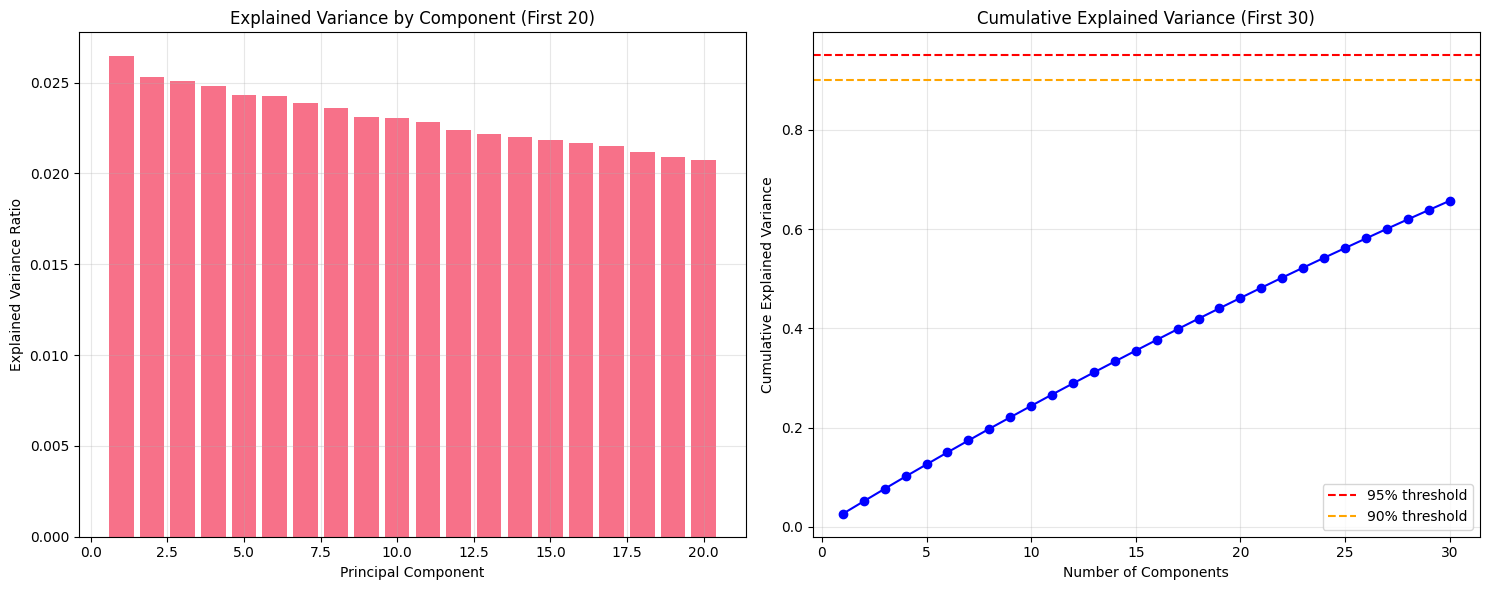


Components for 90% variance: 45
Components for 95% variance: 48


In [5]:
# Plot PCA analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot explained variance ratio
ax1.bar(range(1, min(21, len(explained_variance_ratio) + 1)),
        explained_variance_ratio[:20])
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance by Component (First 20)')
ax1.grid(True, alpha=0.3)

# Plot cumulative explained variance
ax2.plot(range(1, min(31, len(cumulative_variance) + 1)),
         cumulative_variance[:30], 'bo-')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance (First 30)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal number of components
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"\nComponents for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")

## 3. Feature Importance Analysis

In [6]:
# Extract feature importance from PCA components
def get_feature_importance_from_pca(pca_model, feature_names, n_components=None):
    """Calculate feature importance based on PCA loadings"""
    if n_components is None:
        n_components = len(pca_model.explained_variance_ratio_)

    # Get loadings (components) weighted by explained variance
    loadings = pca_model.components_[:n_components]
    weights = pca_model.explained_variance_ratio_[:n_components]

    # Calculate weighted feature importance
    weighted_loadings = loadings * weights.reshape(-1, 1)
    feature_importance = np.sum(np.abs(weighted_loadings), axis=0)

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    return importance_df

# Get feature importance using 95% variance components
importance_df = get_feature_importance_from_pca(pca_full, feature_names, n_components_95)

print("Top 20 Most Important Features (PCA-based):")
print(importance_df.head(20))

Top 20 Most Important Features (PCA-based):
                          feature  importance
19                          HbA1c    0.115314
31                 CholesterolLDL    0.114440
32                 CholesterolHDL    0.113474
7              AlcoholConsumption    0.113033
20                SerumCreatinine    0.112312
46  OccupationalExposureChemicals    0.111704
48       MedicalCheckupsFrequency    0.111447
12      FamilyHistoryHypertension    0.111335
35                      Diuretics    0.111084
34                  ACEInhibitors    0.110537
50                 HealthLiteracy    0.110499
33       CholesterolTriglycerides    0.110367
3             SocioeconomicStatus    0.110038
8                PhysicalActivity    0.109973
4                  EducationLevel    0.109777
13          FamilyHistoryDiabetes    0.109771
25        SerumElectrolytesSodium    0.109687
11     FamilyHistoryKidneyDisease    0.109609
0                             Age    0.109585
30               CholesterolTotal   

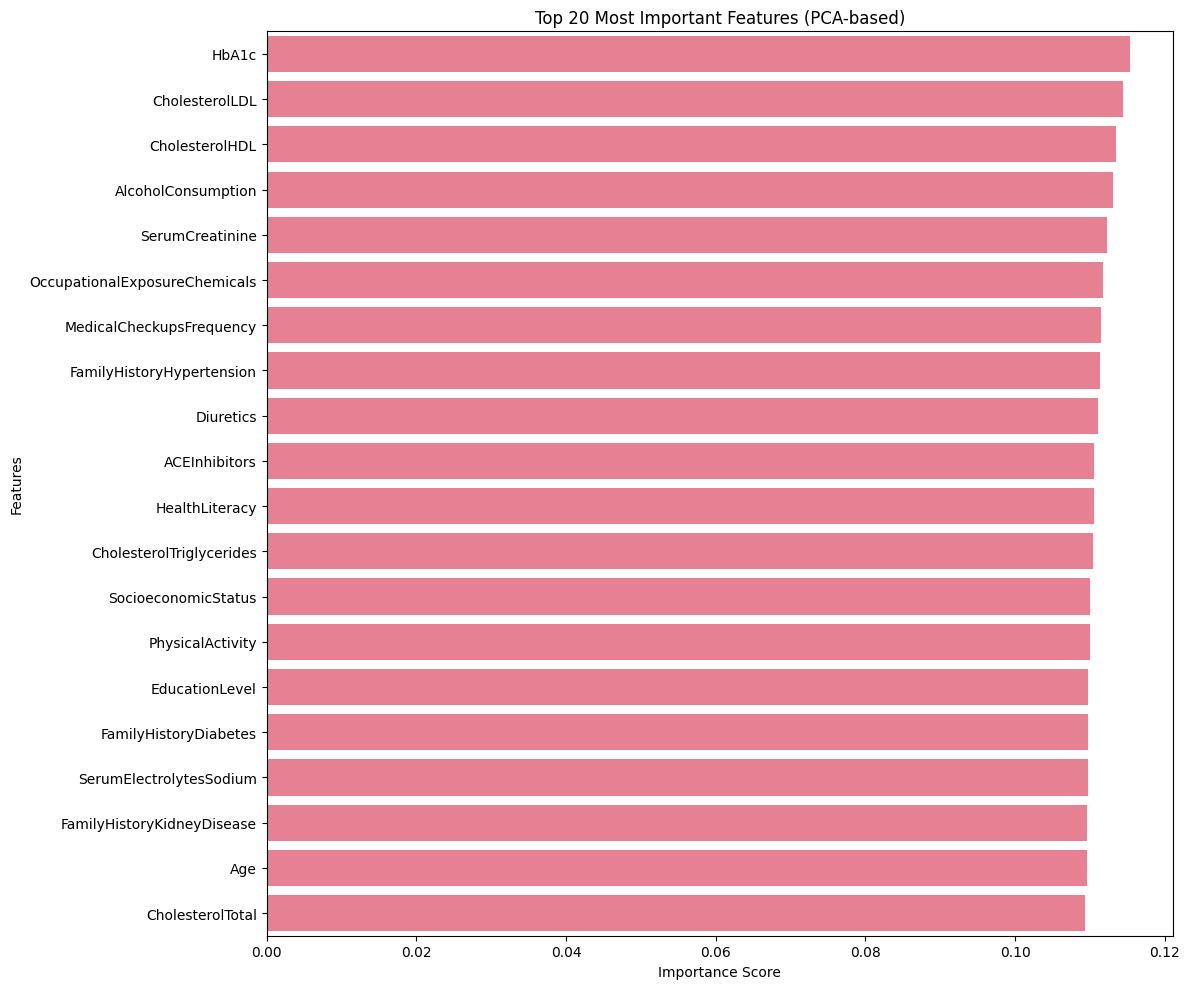


Selected top 15 features for modeling:
 1. HbA1c
 2. CholesterolLDL
 3. CholesterolHDL
 4. AlcoholConsumption
 5. SerumCreatinine
 6. OccupationalExposureChemicals
 7. MedicalCheckupsFrequency
 8. FamilyHistoryHypertension
 9. Diuretics
10. ACEInhibitors
11. HealthLiteracy
12. CholesterolTriglycerides
13. SocioeconomicStatus
14. PhysicalActivity
15. EducationLevel


In [7]:
# Plot feature importance
plt.figure(figsize=(12, 10))
top_20_features = importance_df.head(20)

sns.barplot(data=top_20_features, y='feature', x='importance')
plt.title('Top 20 Most Important Features (PCA-based)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Select top features for modeling
top_15_features = importance_df.head(15)['feature'].tolist()
print(f"\nSelected top 15 features for modeling:")
for i, feature in enumerate(top_15_features, 1):
    print(f"{i:2d}. {feature}")

## 4. Alternative Feature Selection Methods

In [8]:
# Compare different feature selection methods
def compare_feature_selection_methods(X, y, feature_names, n_features=15):
    """Compare PCA, univariate, and mutual information feature selection"""
    results = {}

    # 1. PCA-based (already calculated)
    results['PCA'] = top_15_features

    # 2. Univariate statistical test
    selector_univariate = SelectKBest(score_func=f_classif, k=n_features)
    X_univariate = selector_univariate.fit_transform(X, y)
    univariate_indices = selector_univariate.get_support(indices=True)
    results['Univariate'] = [feature_names[i] for i in univariate_indices]

    # 3. Mutual information
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_mi = selector_mi.fit_transform(X, y)
    mi_indices = selector_mi.get_support(indices=True)
    results['Mutual_Info'] = [feature_names[i] for i in mi_indices]

    return results

feature_selection_results = compare_feature_selection_methods(X, y, feature_names)

# Display comparison
print("Feature Selection Method Comparison:")
print("=" * 50)
for method, features in feature_selection_results.items():
    print(f"\n{method} Method:")
    for i, feature in enumerate(features, 1):
        print(f"{i:2d}. {feature}")

Feature Selection Method Comparison:

PCA Method:
 1. HbA1c
 2. CholesterolLDL
 3. CholesterolHDL
 4. AlcoholConsumption
 5. SerumCreatinine
 6. OccupationalExposureChemicals
 7. MedicalCheckupsFrequency
 8. FamilyHistoryHypertension
 9. Diuretics
10. ACEInhibitors
11. HealthLiteracy
12. CholesterolTriglycerides
13. SocioeconomicStatus
14. PhysicalActivity
15. EducationLevel

Univariate Method:
 1. BMI
 2. DietQuality
 3. FamilyHistoryKidneyDisease
 4. SystolicBP
 5. FastingBloodSugar
 6. HbA1c
 7. SerumCreatinine
 8. BUNLevels
 9. GFR
10. ProteinInUrine
11. HemoglobinLevels
12. CholesterolHDL
13. Edema
14. MuscleCramps
15. Itching

Mutual_Info Method:
 1. Gender
 2. Ethnicity
 3. EducationLevel
 4. PhysicalActivity
 5. FamilyHistoryDiabetes
 6. SystolicBP
 7. FastingBloodSugar
 8. SerumCreatinine
 9. BUNLevels
10. GFR
11. ProteinInUrine
12. SerumElectrolytesSodium
13. CholesterolTotal
14. CholesterolHDL
15. NSAIDsUse


In [9]:
# Find common features across methods
pca_set = set(feature_selection_results['PCA'])
univariate_set = set(feature_selection_results['Univariate'])
mi_set = set(feature_selection_results['Mutual_Info'])

# Find intersection
common_all = pca_set & univariate_set & mi_set
common_pca_uni = pca_set & univariate_set
common_pca_mi = pca_set & mi_set

print(f"Features selected by ALL methods ({len(common_all)}):")
for feature in sorted(common_all):
    print(f"  - {feature}")

print(f"\nFeatures selected by PCA + Univariate ({len(common_pca_uni)}):")
for feature in sorted(common_pca_uni):
    print(f"  - {feature}")

# Create consensus feature set (features selected by at least 2 methods)
consensus_features = list(common_pca_uni | common_pca_mi | (univariate_set & mi_set))
print(f"\nConsensus features (selected by ≥2 methods): {len(consensus_features)}")
for feature in sorted(consensus_features):
    print(f"  - {feature}")

Features selected by ALL methods (2):
  - CholesterolHDL
  - SerumCreatinine

Features selected by PCA + Univariate (3):
  - CholesterolHDL
  - HbA1c
  - SerumCreatinine

Consensus features (selected by ≥2 methods): 10
  - BUNLevels
  - CholesterolHDL
  - EducationLevel
  - FastingBloodSugar
  - GFR
  - HbA1c
  - PhysicalActivity
  - ProteinInUrine
  - SerumCreatinine
  - SystolicBP


## 5. Model Training with Selected Features

In [10]:
# Define models to train
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB()
}

# Function to evaluate models
def evaluate_model_with_features(X, y, feature_subset, models, test_size=0.2):
    """Train and evaluate models with specific feature subset"""
    # Select features
    X_subset = X[feature_subset]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y, test_size=test_size, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}

    for name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba)
        }

    return results, scaler

print("Training models with different feature sets...")

Training models with different feature sets...


In [11]:
# Compare performance with different feature sets
feature_sets = {
    'All Features': feature_names,
    'PCA Top 15': feature_selection_results['PCA'],
    'Univariate Top 15': feature_selection_results['Univariate'],
    'Mutual Info Top 15': feature_selection_results['Mutual_Info'],
    'Consensus Features': consensus_features
}

comparison_results = {}

for set_name, features in feature_sets.items():
    print(f"\nEvaluating with {set_name} ({len(features)} features)...")
    results, _ = evaluate_model_with_features(X, y, features, models)
    comparison_results[set_name] = results

print("\nModel evaluation completed!")


Evaluating with All Features (51 features)...

Evaluating with PCA Top 15 (15 features)...

Evaluating with Univariate Top 15 (15 features)...

Evaluating with Mutual Info Top 15 (15 features)...

Evaluating with Consensus Features (10 features)...

Model evaluation completed!


In [12]:
# Create comprehensive comparison table
def create_comparison_table(comparison_results):
    """Create a comprehensive comparison table"""
    rows = []

    for feature_set, models_results in comparison_results.items():
        for model_name, metrics in models_results.items():
            row = {
                'Feature_Set': feature_set,
                'Model': model_name,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1_Score': metrics['f1'],
                'AUC': metrics['auc']
            }
            rows.append(row)

    return pd.DataFrame(rows)

comparison_df = create_comparison_table(comparison_results)

# Display results
print("\nPerformance Comparison Across Feature Sets:")
print("=" * 80)
print(comparison_df.round(4))


Performance Comparison Across Feature Sets:
           Feature_Set                Model  Accuracy  Precision  Recall  \
0         All Features        Random Forest    0.9217     0.9215  1.0000   
1         All Features    Gradient Boosting    0.9247     0.9348  0.9869   
2         All Features  Logistic Regression    0.9187     0.9344  0.9803   
3         All Features                  SVM    0.9187     0.9187  1.0000   
4         All Features          Naive Bayes    0.9157     0.9369  0.9738   
5           PCA Top 15        Random Forest    0.9187     0.9187  1.0000   
6           PCA Top 15    Gradient Boosting    0.9096     0.9231  0.9836   
7           PCA Top 15  Logistic Regression    0.9187     0.9187  1.0000   
8           PCA Top 15                  SVM    0.9187     0.9187  1.0000   
9           PCA Top 15          Naive Bayes    0.9157     0.9184  0.9967   
10   Univariate Top 15        Random Forest    0.9277     0.9271  1.0000   
11   Univariate Top 15    Gradient Boosting

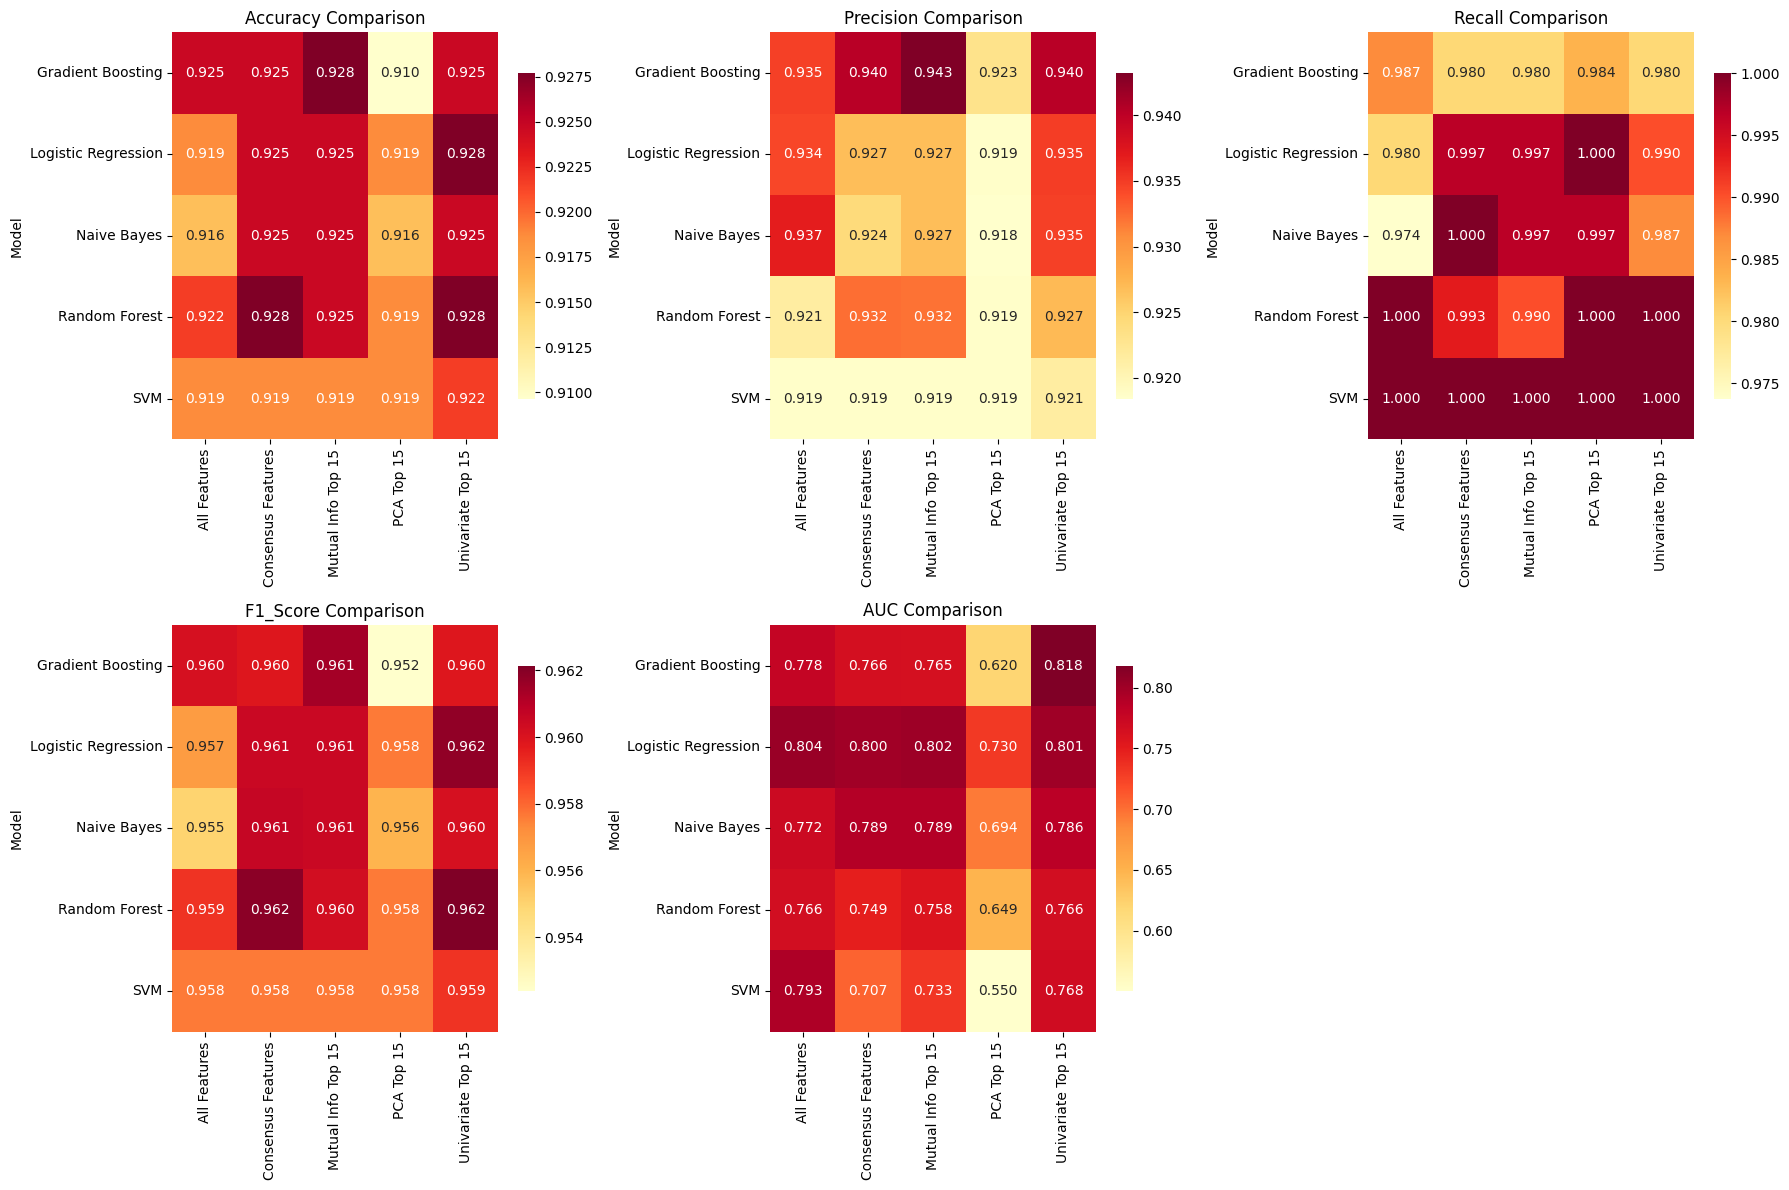

In [13]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC']

for i, metric in enumerate(metrics):
    pivot_data = comparison_df.pivot(index='Model', columns='Feature_Set', values=metric)

    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd',
                ax=axes[i], cbar_kws={'shrink': 0.8})
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xlabel('')

# Remove empty subplot
axes[5].remove()

plt.tight_layout()
plt.show()

## 6. Best Model Selection and Saving

In [14]:
# Find best performing model and feature set combination
best_auc = comparison_df.loc[comparison_df['AUC'].idxmax()]
best_f1 = comparison_df.loc[comparison_df['F1_Score'].idxmax()]

print("Best Performance Results:")
print("=" * 40)
print(f"Best AUC: {best_auc['AUC']:.4f}")
print(f"Model: {best_auc['Model']}")
print(f"Feature Set: {best_auc['Feature_Set']}")
print()
print(f"Best F1-Score: {best_f1['F1_Score']:.4f}")
print(f"Model: {best_f1['Model']}")
print(f"Feature Set: {best_f1['Feature_Set']}")

# Select the best combination (prioritizing AUC)
best_model_name = best_auc['Model']
best_feature_set_name = best_auc['Feature_Set']
best_features = feature_sets[best_feature_set_name]

print(f"\nSelected for production: {best_model_name} with {best_feature_set_name}")
print(f"Number of features: {len(best_features)}")

Best Performance Results:
Best AUC: 0.8181
Model: Gradient Boosting
Feature Set: Univariate Top 15

Best F1-Score: 0.9621
Model: Random Forest
Feature Set: Univariate Top 15

Selected for production: Gradient Boosting with Univariate Top 15
Number of features: 15


In [15]:
# Train final model with best configuration
print(f"Training final model: {best_model_name} with {len(best_features)} features...")

# Prepare data with best features
X_best = X[best_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_best, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train)
X_test_scaled = final_scaler.transform(X_test)

# Train final model
final_model = models[best_model_name]
final_model.fit(X_train_scaled, y_train)

# Final evaluation
y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

print("\nFinal Model Performance:")
print("=" * 30)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training final model: Gradient Boosting with 15 features...

Final Model Performance:
Accuracy: 0.9247
Precision: 0.9403
Recall: 0.9803
F1-Score: 0.9599
AUC: 0.8181

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.30      0.39        27
           1       0.94      0.98      0.96       305

    accuracy                           0.92       332
   macro avg       0.76      0.64      0.68       332
weighted avg       0.91      0.92      0.91       332



In [16]:
# Save the final model and components
import os

# Create directory for saved models
os.makedirs('saved_models_pca', exist_ok=True)

# Save model, scaler, and feature list
joblib.dump(final_model, 'saved_models_pca/best_ckd_model.pkl')
joblib.dump(final_scaler, 'saved_models_pca/feature_scaler.pkl')
joblib.dump(best_features, 'saved_models_pca/selected_features.pkl')

# Save feature importance and analysis results
importance_df.to_csv('saved_models_pca/feature_importance_pca.csv', index=False)
comparison_df.to_csv('saved_models_pca/model_comparison_results.csv', index=False)

# Create a summary report
summary_report = {
    'best_model': best_model_name,
    'best_feature_set': best_feature_set_name,
    'n_features': len(best_features),
    'selected_features': best_features,
    'performance': {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba)
    },
    'pca_analysis': {
        'components_for_95_variance': n_components_95,
        'components_for_90_variance': n_components_90
    }
}

import json
with open('saved_models_pca/model_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print("\nModel and analysis results saved to 'saved_models_pca/' directory:")
print("- best_ckd_model.pkl (trained model)")
print("- feature_scaler.pkl (feature scaler)")
print("- selected_features.pkl (feature list)")
print("- feature_importance_pca.csv (PCA feature importance)")
print("- model_comparison_results.csv (performance comparison)")
print("- model_summary.json (summary report)")

print(f"\nFinal selected features ({len(best_features)}):")
for i, feature in enumerate(best_features, 1):
    print(f"{i:2d}. {feature}")


Model and analysis results saved to 'saved_models_pca/' directory:
- best_ckd_model.pkl (trained model)
- feature_scaler.pkl (feature scaler)
- selected_features.pkl (feature list)
- feature_importance_pca.csv (PCA feature importance)
- model_comparison_results.csv (performance comparison)
- model_summary.json (summary report)

Final selected features (15):
 1. BMI
 2. DietQuality
 3. FamilyHistoryKidneyDisease
 4. SystolicBP
 5. FastingBloodSugar
 6. HbA1c
 7. SerumCreatinine
 8. BUNLevels
 9. GFR
10. ProteinInUrine
11. HemoglobinLevels
12. CholesterolHDL
13. Edema
14. MuscleCramps
15. Itching


## 7. Integration Instructions for Django Backend

To integrate this optimized model into your Django backend:

1. **Copy the saved model files** to your Django project
2. **Update `ml_service.py`** to load the real trained model
3. **Use only the selected features** for predictions
4. **Apply the same feature scaling** as used in training

Example integration code for `ml_predictions/ml_service.py`:

In [17]:
# Example integration code (for reference)
integration_code = '''
import joblib
import numpy as np

class MLService:
    def __init__(self):
        # Load trained model and components
        self.model = joblib.load('saved_models_pca/best_ckd_model.pkl')
        self.scaler = joblib.load('saved_models_pca/feature_scaler.pkl')
        self.selected_features = joblib.load('saved_models_pca/selected_features.pkl')
        self.model_version = "2.0.0-PCA"

    def extract_features(self, patient):
        """Extract only the selected features from patient data"""
        # Map patient data to selected features
        feature_values = []
        for feature in self.selected_features:
            # Map feature names to patient data fields
            value = self.get_patient_feature_value(patient, feature)
            feature_values.append(value)
        return np.array(feature_values).reshape(1, -1)

    def predict_ckd_risk(self, patient):
        # Extract and scale features
        features = self.extract_features(patient)
        features_scaled = self.scaler.transform(features)

        # Make prediction
        prediction = self.model.predict(features_scaled)[0]
        confidence = self.model.predict_proba(features_scaled)[0].max() * 100
        return {
            'result': 'CKD Positive' if prediction == 1 else 'CKD Negative',
            'confidence': round(confidence, 2),
            'risk_level': self.get_risk_level(prediction, confidence),
            'model_version': self.model_version
        }
'''

print("Integration code template:")
print(integration_code)

Integration code template:

import joblib
import numpy as np

class MLService:
    def __init__(self):
        # Load trained model and components
        self.model = joblib.load('saved_models_pca/best_ckd_model.pkl')
        self.scaler = joblib.load('saved_models_pca/feature_scaler.pkl')
        self.selected_features = joblib.load('saved_models_pca/selected_features.pkl')
        self.model_version = "2.0.0-PCA"
    
    def extract_features(self, patient):
        """Extract only the selected features from patient data"""
        # Map patient data to selected features
        feature_values = []
        for feature in self.selected_features:
            # Map feature names to patient data fields
            value = self.get_patient_feature_value(patient, feature)
            feature_values.append(value)
        return np.array(feature_values).reshape(1, -1)
    
    def predict_ckd_risk(self, patient):
        # Extract and scale features
        features = self.extract_features(